## Tutorial notebook of predicting on unseen samples with trained CRISP model

In this notebook, we show user how to perform inference on unseen samples with trained CRISP model. \
There are two examples: (1). Predict for unseen cell types within NeurIPS dataset. (2). Predict across batches from unseen dataset (PBMC-Bench)

In [1]:
import numpy as np
import CRISP.trainer as ct
import scanpy as sc
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

### Predict within dataset

In [3]:
# load anndata containing control and perturbed data
nips = sc.read('nips_pp_scFM_resplit.h5ad')
var_names = nips.var_names
gene_to_id = dict(zip(var_names,range(len(var_names))))

# load drug embeddings
drug_to_smile = dict(zip(nips.obs['condition'],nips.obs['SMILES']))
smile_df = pd.read_parquet('../data/drug_embeddings/rdkit2D_embedding_lincs_nips.parquet')

In [204]:
# get control state samples waited to be predicted
adata_ctrl = nips[(nips.obs['neg_control']==1) & (nips.obs['split2']=='ood') & (nips.obs['cell_type']=='B cells')]

In [206]:
# perturbation condition
drug = 'Palbociclib'
dose = 0.07092198581560284
smile = drug_to_smile[drug]

In [208]:
# load trained model 
# we provide parameters file of trained model from NeurIPS dataset (split2: trained from CD8+ T cells, NK cells, T regulatory cells and Myeloid cells)
# and you can also train it by yourself
exp = ct.Trainer()
model_path = 'model_weights/nips_split2_model.pt'
exp.load_model(model_path)

In [209]:
# prediction
adata_pred, adata_lat, _ = exp.get_prediction(adata_ctrl,dose=dose,smile=smile,smile_df=smile_df,FM_emb='X_scGPT')

visualization using scatter plot 

In [212]:
adata_true = nips[(nips.obs['split2']=='ood') & (nips.obs['cell_type']=='B cells') & (nips.obs['condition']==drug)].copy()

de_genes = nips.uns['rank_genes_groups_cov']
var_names = nips.var_names
des = de_genes[f'B cells_{drug}']
de_bool = var_names.isin(np.array(des))
idx_de = np.where(de_bool)[0]
yt = np.array(adata_true.X.mean(0)).flatten()
yp = np.array(adata_pred.X.mean(0)).flatten()
ctrl = np.array(adata_ctrl.X.mean(0)).flatten()
yt_delta = yt-ctrl
yp_delta = yp-ctrl
data_df = pd.DataFrame({'gt':yt_delta,'pred':yp_delta,'de':de_bool})
df_sorted = data_df.sort_values(by='de', ascending=True)

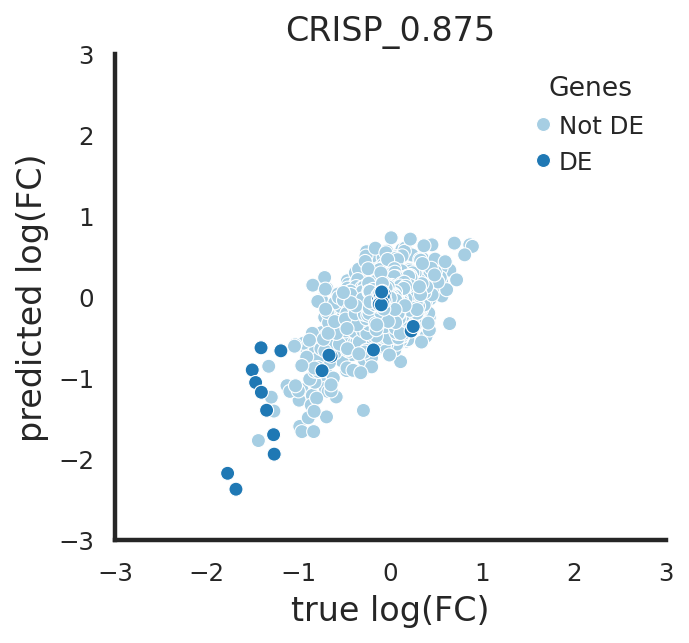

In [213]:
sns.set_theme(style="white", palette=None)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.scatterplot(data=df_sorted,x='gt',y='pred',hue='de',s=40,palette="Paired")
# plt.plot([0,0], [3,3], color='orange', linestyle='--', label='diag')
sns.despine()
pr = round(pearsonr(data_df['pred'][idx_de], data_df['gt'][idx_de])[0],3)
plt.title(f'CRISP_{pr}',fontsize=15)
plt.xlabel('true log(FC)',fontsize=15)
plt.ylabel('predicted log(FC)',fontsize=15)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2) 
legend = ax.legend(title='Genes')
new_labels = ['Not DE', 'DE']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
legend.set_frame_on(False)

### Predict across dataset

In [127]:
pbmc_bench = sc.read('pbmc_bench_pp_all.h5ad')

In [239]:
# set control samples to be predicted
pbmc_bench_ctrl = pbmc_bench.copy()

In [240]:
# perturbation condition
drug = 'Dactolisib'
dose = 0.07092198581560284
smile = drug_to_smile[drug]

In [ ]:
# load trained model (this model trained from CD4+ T cells, NK cells, CD8+ T cells, B cells), and we apply it to PBMC-Bench dataset
exp = ct.Trainer()
model_path = 'model_weights/nips_split_model.pt'
exp.load_model(model_path)

In [ ]:
adata_pred, adata_lat, _ = exp.get_prediction(adata_ctrl,dose=dose,smile=smile,smile_df=smile_df,FM_emb='X_scGPT')

evaluation and visualization

In [252]:
# we use neurips dataset as reference, therefore, we need to evaluate on the overlapping gene set between pbmc-bench and neurips
over = set(pbmc_bench.var['gene_name'].tolist()).intersection(set(nips.var['gene_id'].tolist()))
nips_subgenes = nips[:,nips.var['gene_id'].isin(over)]
var_names = nips_subgenes.var_names
for k,v in de_genes.items():
    v_ = [i for i in v if i in var_names]
    de_genes[k] = v_

In [253]:
# control and ground truth from neurips dataset
adata_ctrl_nips = nips_subgenes[(nips_subgenes.obs['neg_control']==1) & (nips_subgenes.obs['cell_type']=='NK cells')]
adata_treated = nips_subgenes[(nips_subgenes.obs['condition']==drug) & (nips_subgenes.obs['dose_val']==dose) & (nips_subgenes.obs['cell_type']=='NK cells')]

# control and perturbation prediction from pbmc-bench dataset
pbmc_bench_ctrl.var_names = pbmc_bench_ctrl.var['gene_name'].astype('str')
unique_var_mask = ~pbmc_bench_ctrl.var_names.duplicated(keep='first')
pbmc_bench_ctrl_unique = pbmc_bench_ctrl[:, unique_var_mask].copy()
adata_ctrl_bench = pbmc_bench_ctrl_unique[(pbmc_bench_ctrl_unique.obs['Method']=='10x Chromium (v3)') & (pbmc_bench_ctrl_unique.obs['cell_type']=='Natural killer cell')]
adata_ctrl_bench = adata_ctrl_bench[:,adata_ctrl_nips.var_names]

adata_pred_sub = adata_pred[(adata_pred.obs['Method']=='10x Chromium (v3)') & (adata_pred.obs['cell_type']=='Natural killer cell')]
adata_pred_sub.var = nips.var.copy()
adata_pred_sub = adata_pred_sub[:,adata_pred_sub.var['gene_id'].isin(list(over))].copy()

In [254]:
des = de_genes[f'NK cells_{drug}']
var_names = adata_treated.var_names
de_bool = var_names.isin(np.array(des))
idx_de = np.where(de_bool)[0]
yt = np.array(adata_treated.X.mean(0)).flatten()
yp = np.array(adata_pred_sub.X.mean(0)).flatten()
ctrl_bench = np.array(adata_ctrl_bench.X.mean(0)).flatten()
ctrl_nips = np.array(adata_ctrl_nips.X.mean(0)).flatten()
yt_delta = yt-ctrl_nips
yp_delta = yp-ctrl_bench
data_df = pd.DataFrame({'gt':yt_delta,'pred':yp_delta,'de':de_bool})
df_sorted = data_df.sort_values(by='de', ascending=True)

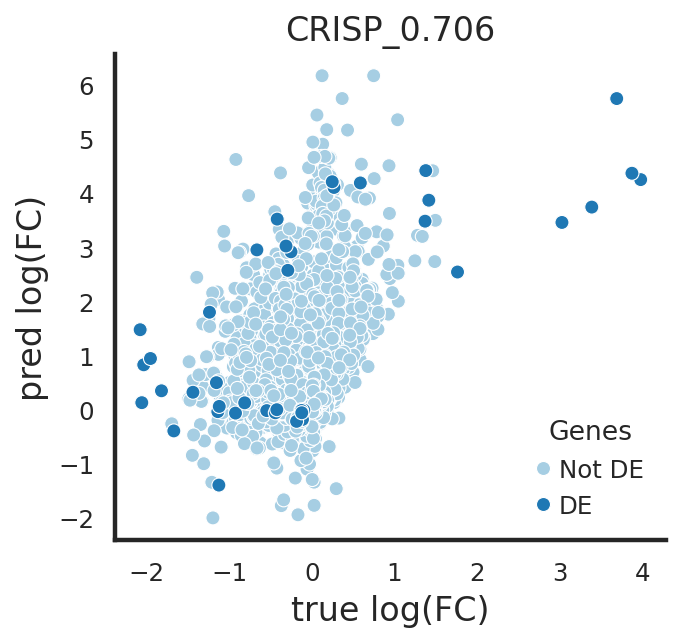

In [255]:
sns.set_theme(style="white", palette=None)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.scatterplot(data=df_sorted,x='gt',y='pred',hue='de',s=40,palette="Paired")
sns.despine()
pr = round(pearsonr(data_df['pred'][idx_de], data_df['gt'][idx_de])[0],3)
plt.title(f'CRISP_{pr}',fontsize=15)
plt.xlabel('true log(FC)',fontsize=15)
plt.ylabel('pred log(FC)',fontsize=15)

ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2) 
legend = ax.legend(title='Genes')
new_labels = ['Not DE', 'DE']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
legend.set_frame_on(False)

umap

In [219]:
custom_params = [
 '#023fa5',
 '#bec1d4',
 '#d6bcc0',
 '#bb7784',
 '#8595e1',
 '#e07b91',
 '#d33f6a',
 '#8dd593',
 '#c6dec7',
 '#f0b98d',
 '#ef9708',
 '#9cded6',
 '#d5eae7',
 '#f3e1eb']

/ailab/group/groups/aim/liuxinyuan/.conda/envs/scgpt/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 33694 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


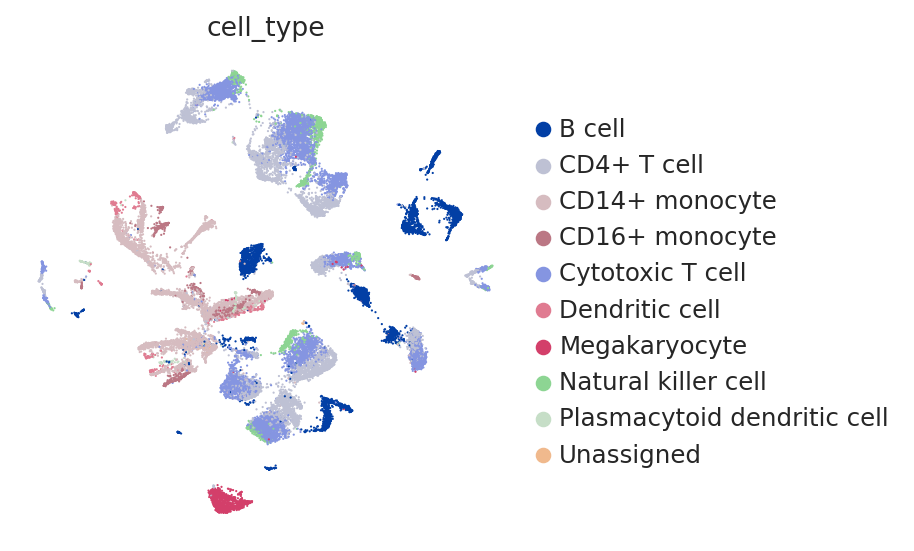

In [256]:
sc.pp.neighbors(pbmc_bench_ctrl)
sc.tl.umap(pbmc_bench_ctrl, min_dist=0.3)
fig = sc.pl.umap(
    pbmc_bench_ctrl,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
    palette=custom_params,
)

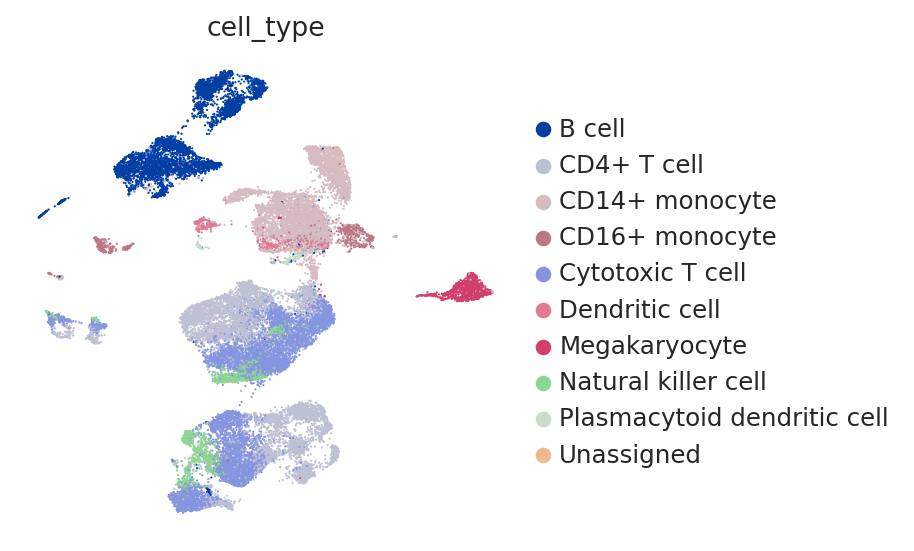

In [220]:
sc.pp.neighbors(pbmc_bench_ctrl, use_rep='X_scGPT_blood')
sc.tl.umap(pbmc_bench_ctrl, min_dist=0.3)
fig = sc.pl.umap(
    pbmc_bench_ctrl,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
    palette=custom_params,
)

/ailab/group/groups/aim/liuxinyuan/.conda/envs/scgpt/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 256 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


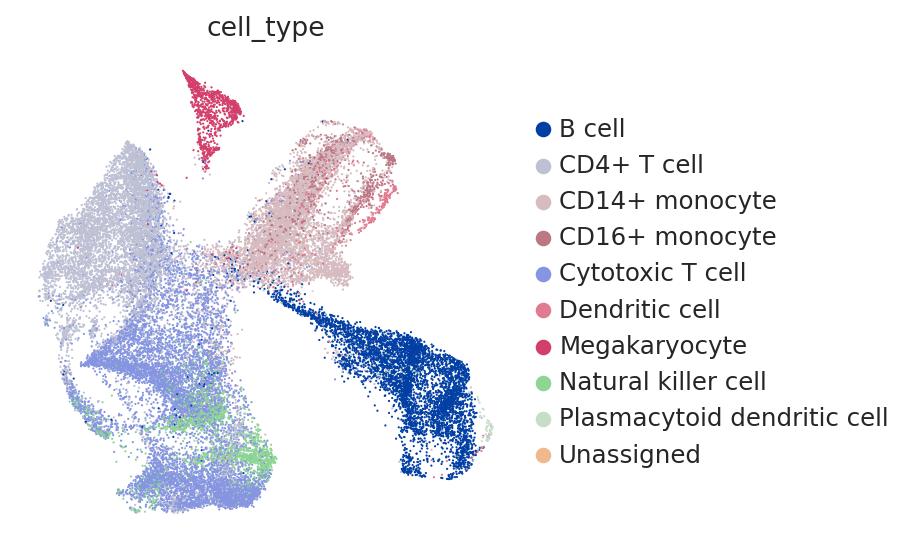

In [223]:
sc.pp.neighbors(adata_lat)
sc.tl.umap(adata_lat, min_dist=0.3)
fig = sc.pl.umap(
    adata_lat,
    color=["cell_type"],
    frameon=False,
    return_fig=True,
    show=False,
    palette=custom_params
)